In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import uproot
import awkward as ak

In [2]:
plt.rc('font', size=14)

In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Background Substraction using Variational Autoencoders

In [4]:
# Load E906 data
tree = uproot.open("LH2Data.root:tree")
events = tree.arrays(["mass", "pT", "xF", "phi", "costh", "weight"])

X = np.array([(mass, pT, xF, phi, costh) for mass, pT, xF, phi, costh in zip(events.mass, events.pT, events.xF, events.phi, events.costh)])
weight = np.array([(weight) for weight in events.weight]).reshape(-1, 1)

In [5]:
# Some const.

batch_size = 100
num_epochs = 2000

In [6]:
# Convert to torch tensor

X_tensor = torch.from_numpy(X).float()
weight_tensor = torch.from_numpy(weight).float()

dataset = TensorDataset(X_tensor, weight_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Define the Variational Autoencoder (VAE) architecture

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim, bias=True)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim, bias=True)
        self.fc4 = nn.Linear(latent_dim, hidden_dim, bias=True)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc6 = nn.Linear(hidden_dim, input_dim, bias=True)
        self.relu = nn.ReLU()
        
    def encode(self, x):
        h = self.relu(self.fc1(x))
        h = self.relu(self.fc2(h))
        h = self.relu(self.fc3(h))
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def decode(self, z):
        h = self.relu(self.fc4(z))
        h = self.relu(self.fc5(h))
        return self.fc6(h)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [8]:
# Define the loss function (VAE loss)

def vae_loss(recon_x, x, weight_batch, mu, logvar):
    loss_fn = nn.MSELoss(reduction="sum")
    MSE = loss_fn(recon_x, x)
    MSE_weight = torch.sum(weight_batch * MSE)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # KLD_weight = torch.sum(KLD* batch_size)
    return (MSE_weight + KLD)/ x.size(0)

In [9]:
# Create the VAE
input_dim = 5
hidden_dim = 150
latent_dim = 30
vae = VAE(input_dim, hidden_dim, latent_dim)

In [10]:
# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.0001)

In [11]:
# Training loop
for epoch in range(num_epochs):
    vae.train()
    for batch_data, batch_weight in dataloader:
        optimizer.zero_grad()
        recon_data, mu, logvar = vae(batch_data)  # Use batch_data
        loss = vae_loss(recon_data, batch_data, batch_weight, mu, logvar)  # Use batch_data and batch_weight
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f"===> Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}")

===> Epoch [0/2000], Loss: 125.84903717041016
===> Epoch [100/2000], Loss: 10.191997528076172
===> Epoch [200/2000], Loss: 9.407129287719727
===> Epoch [300/2000], Loss: 9.123475074768066
===> Epoch [400/2000], Loss: 9.287409782409668
===> Epoch [500/2000], Loss: 9.024715423583984
===> Epoch [600/2000], Loss: 8.633170127868652
===> Epoch [700/2000], Loss: 9.037150382995605
===> Epoch [800/2000], Loss: 9.278307914733887
===> Epoch [900/2000], Loss: 9.520730972290039
===> Epoch [1000/2000], Loss: 8.729942321777344
===> Epoch [1100/2000], Loss: 8.465547561645508
===> Epoch [1200/2000], Loss: 9.523618698120117
===> Epoch [1300/2000], Loss: 8.899627685546875
===> Epoch [1400/2000], Loss: 8.939414978027344
===> Epoch [1500/2000], Loss: 8.892729759216309
===> Epoch [1600/2000], Loss: 8.725488662719727
===> Epoch [1700/2000], Loss: 8.04962158203125
===> Epoch [1800/2000], Loss: 9.044108390808105
===> Epoch [1900/2000], Loss: 8.67934513092041


In [12]:
# Generate background-subtracted data

num_samples = events.mass[events.weight == 1].to_numpy().shape[0]

vae.eval()
with torch.no_grad():
    # background_subtracted_data, _, _ = vae(torch.Tensor(X))
    background_subtracted_data = vae.decode(torch.randn(num_samples, latent_dim)).float()

background_subtracted_data = background_subtracted_data.detach().numpy()

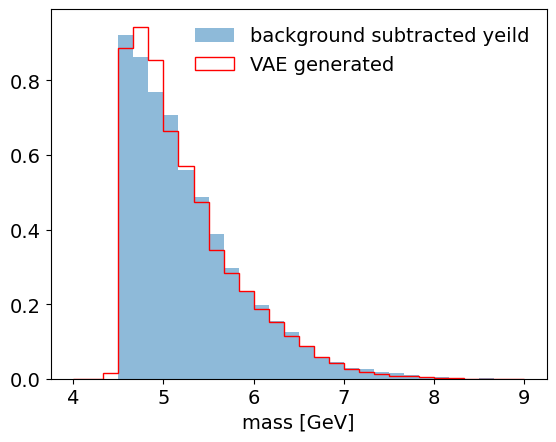

In [13]:
bins = np.linspace(4.0, 9.0, 31)

plt.hist(events.mass, bins=bins, weights=events.weight, alpha=0.5, label="background subtracted yeild", density=True)
plt.hist(background_subtracted_data[:, 0], bins=bins, label="VAE generated", histtype="step", color="red", density=True)
plt.xlabel("mass [GeV]")
plt.legend(frameon=False)
plt.savefig("Tufts-ML2023/slides/imgs/mass.png")
plt.show()

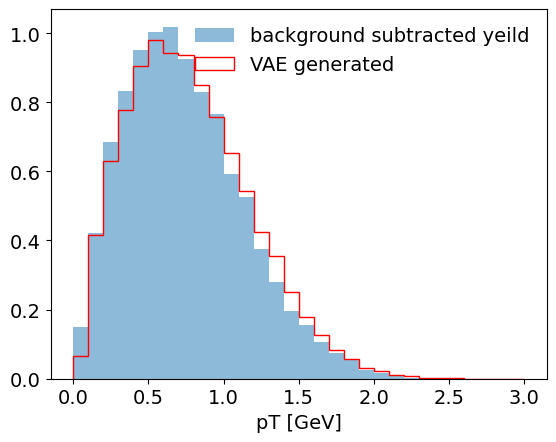

In [14]:
bins = np.linspace(0.0, 3.0, 31)

plt.hist(events.pT, bins=bins, weights=events.weight, alpha=0.5, label="background subtracted yeild", density=True)
plt.hist(background_subtracted_data[:, 1], bins=bins, label="VAE generated", histtype="step", color="red", density=True)
plt.xlabel("pT [GeV]")
plt.legend(frameon=False)
plt.savefig("Tufts-ML2023/slides/imgs/pT.png")
plt.show()

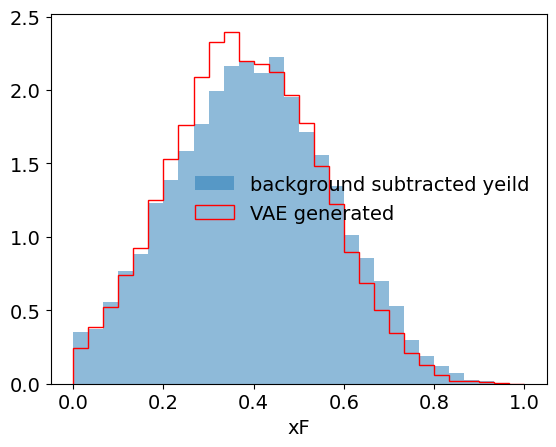

In [15]:
bins = np.linspace(0.0, 1.0, 31)

plt.hist(events.xF, bins=bins, weights=events.weight, alpha=0.5, label="background subtracted yeild", density=True)
plt.hist(background_subtracted_data[:, 2], bins=bins, label="VAE generated", histtype="step", color="red", density=True)
plt.xlabel("xF")
plt.legend(frameon=False)
plt.savefig("Tufts-ML2023/slides/imgs/xF.png")
plt.show()

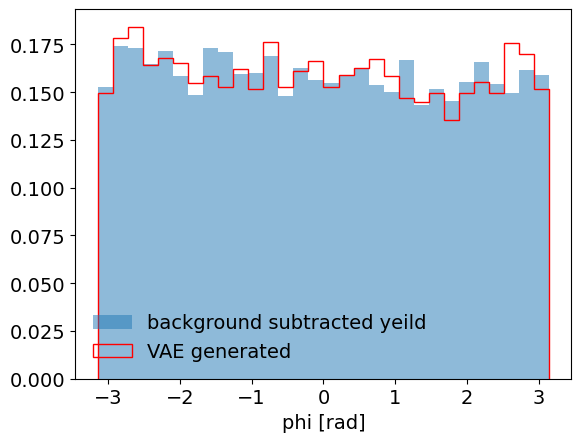

In [16]:
bins = np.linspace(-np.pi, np.pi, 31)

plt.hist(events.phi, bins=bins, weights=events.weight, alpha=0.5, label="background subtracted yeild", density=True)
plt.hist(background_subtracted_data[:, 3], bins=bins, label="VAE generated", histtype="step", color="red", density=True)
plt.xlabel("phi [rad]")
plt.legend(frameon=False)
plt.savefig("Tufts-ML2023/slides/imgs/phi.png")
plt.show()

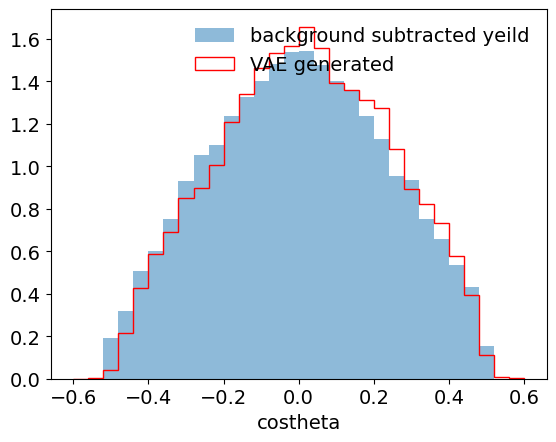

In [17]:
bins = np.linspace(-0.6, 0.6, 31)

plt.hist(events.costh, bins=bins, weights=events.weight, alpha=0.5, label="background subtracted yeild", density=True)
plt.hist(background_subtracted_data[:, 4], bins=bins, label="VAE generated", histtype="step", color="red", density=True)
plt.legend(frameon=False)
plt.xlabel("costheta")
plt.savefig("Tufts-ML2023/slides/imgs/costh.png")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Tufts-ML2023/slides/imgs/cmbg.png'

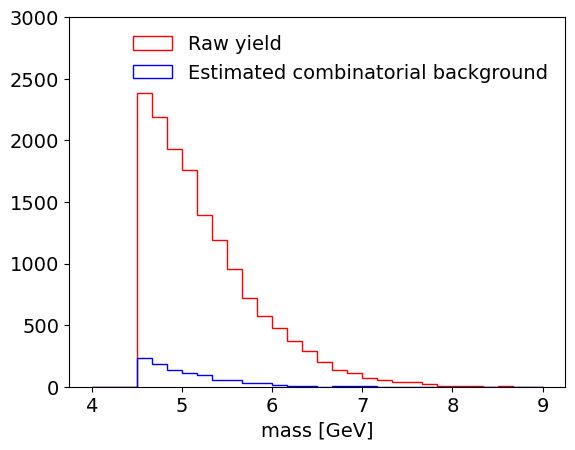

In [5]:
bins = np.linspace(4.0, 9.0, 31)

plt.hist(events.mass[events.weight==1], bins=bins, label="Raw yield", histtype="step", color="red")
plt.hist(events.mass[events.weight==-1], bins=bins, label="Estimated combinatorial background", histtype="step", color="blue")
plt.legend(frameon=False)
plt.xlabel("mass [GeV]")
plt.ylim(0., 3000.)
plt.savefig("Tufts-ML2023/slides/imgs/cmbg.png")
plt.show()